In [1]:
# Allow GPU memory growth
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load and prepare the Pokemon dataset for CNN model

In [4]:
PATH = os.getcwd()
data_path = PATH + '/pokemon dataset'
data_dir_list = os.listdir(data_path)

In [5]:
IMAGE_DIMS = (128, 128, 3)
resizeImages = []

for dataset in data_dir_list:
    img_list = os.listdir(data_path + '/' + dataset)
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    
    # Resize every image in the dataset to intended dimension
    for img in img_list:
        input_img = cv2.imread(data_path + '/' + dataset + '/' + img)
        input_img = cv2.resize(input_img, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
        input_img = img_to_array(input_img)
        resizeImages.append(input_img)
        
img_data = np.array(resizeImages)
img_data = img_data.astype('float32')
img_data /= 255
print(img_data.shape)

Loaded the images of dataset-balbasaur

Loaded the images of dataset-charmander

Loaded the images of dataset-mewtwo

Loaded the images of dataset-pikachu

Loaded the images of dataset-squirtle

(250, 128, 128, 3)


In [6]:
num_classes = 5

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,), dtype='int64')

labels[0:50] = 0
labels[51:100] = 1
labels[101:150] = 2
labels[151:200] = 3
labels[201:250] = 4

categories = ['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']

# One-hot encoding on the labels
Y = tf.keras.utils.to_categorical(labels, num_classes)

In [7]:
x, y = shuffle(img_data, Y, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

input_shape = img_data[0].shape
print(input_shape)

(128, 128, 3)


### Creation of CNN using Transfer Learning 

Transfer learning is applied by freezing the "deep layers" of the model and only re-training the classification layers.

In [8]:
# Importing VGG16 from keras with pre-trained weights that is trained on imagenet
# Include_top > False to exclude the top classification layer 
# Weights > to use the weights from pre-training on Imagenet

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_DIMS)

for layer in base_model.layers:
     layer.trainable = False

In [9]:
# Build the classification layers on top of the base VGG16 base layers for the dataset
model = tf.keras.Sequential(base_model.layers)

model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

### Train the Model

Use the "transferred" VGG16 model to train on the dataset.

In [11]:
initial_epochs = 8
initial_batch_size = 10

In [12]:
# Enable run function eagerly to use function decorator
tf.config.experimental_run_functions_eagerly(True)

checkpoint_filepath = 'Pokemon_model.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, 
                                                               monitor='val_accuracy', mode='max', save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen so far
history = model.fit(X_train, y_train, validation_split=0.2, epochs=initial_epochs, 
                    batch_size=initial_batch_size, verbose=0, 
                    callbacks=[model_checkpoint_callback])

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('test_loss:', test_loss)
print('test_acc:', test_acc)

test_loss: 0.5442808270454407
test_acc: 0.8399999737739563


### Learning Curves

Plot learning curves of the training and validation accuracy/ loss when using the "transferred" VGG16 base model.

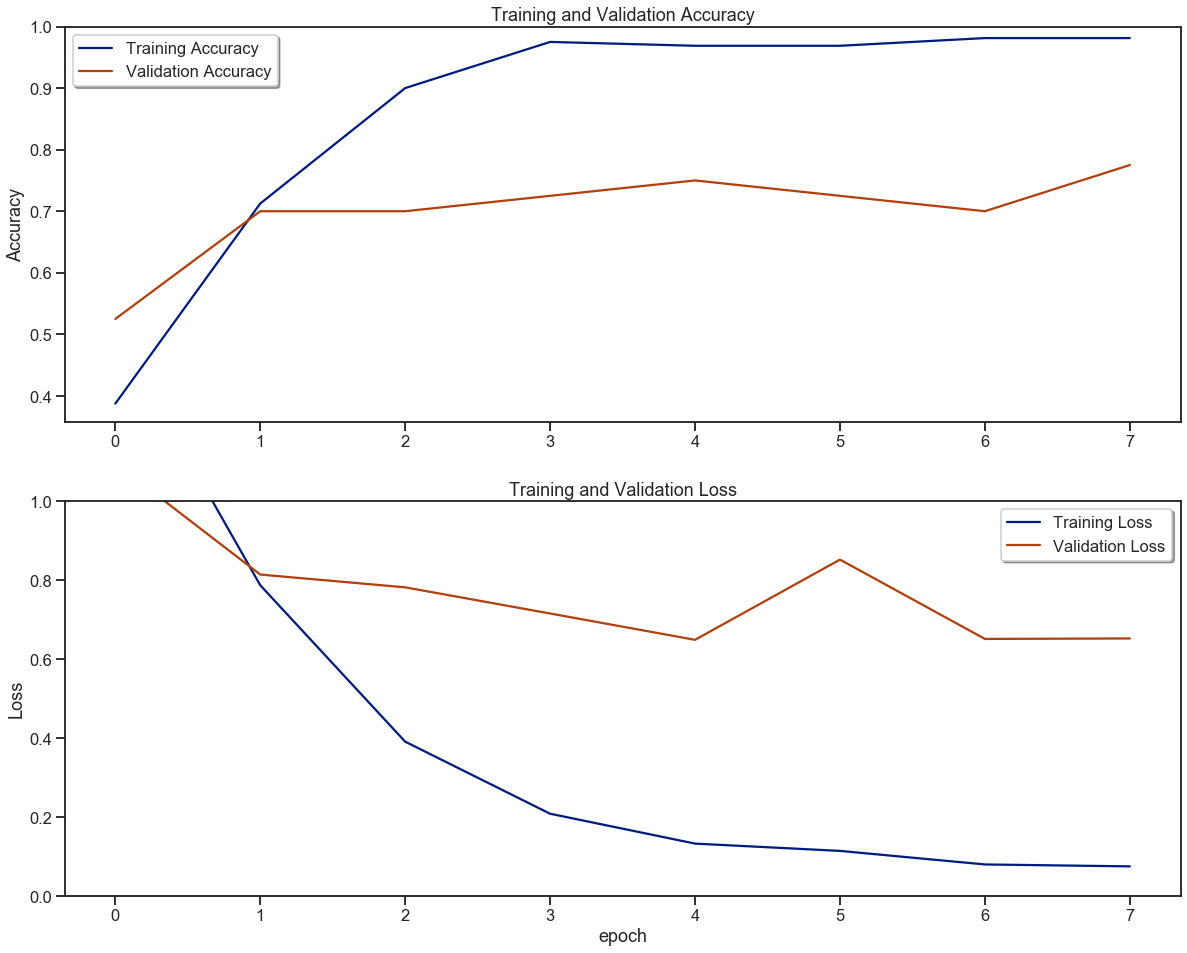

In [13]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='best', shadow=True)
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='best', shadow=True)
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning of CNN model 

Fine tune and compile the model using a much lower learning rate.

In [14]:
base_model = tf.keras.applications.VGG16(include_top=False, weights=None)

# The model weights (that are considered the best) are loaded into the model
model.load_weights(checkpoint_filepath) 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

Continue training the model to improve the test accuracy and test loss.

In [15]:
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs

final_batch_size = 5

history_fine = model.fit(X_train, y_train, validation_split=0.2, epochs=total_epochs, 
                         initial_epoch= history.epoch[-1], batch_size=final_batch_size, verbose=0)

test_loss_fine, test_acc_fine = model.evaluate(X_test, y_test, verbose=0)
print('test_loss_fine_tuned:', test_loss_fine)
print('test_acc_fine_tuned:', test_acc_fine)

test_loss_fine_tuned: 0.5220604538917542
test_acc_fine_tuned: 0.800000011920929


### Learning Curves after fine tuning

Plot learning curves of the training and validation accuracy/ loss after fine tuning.

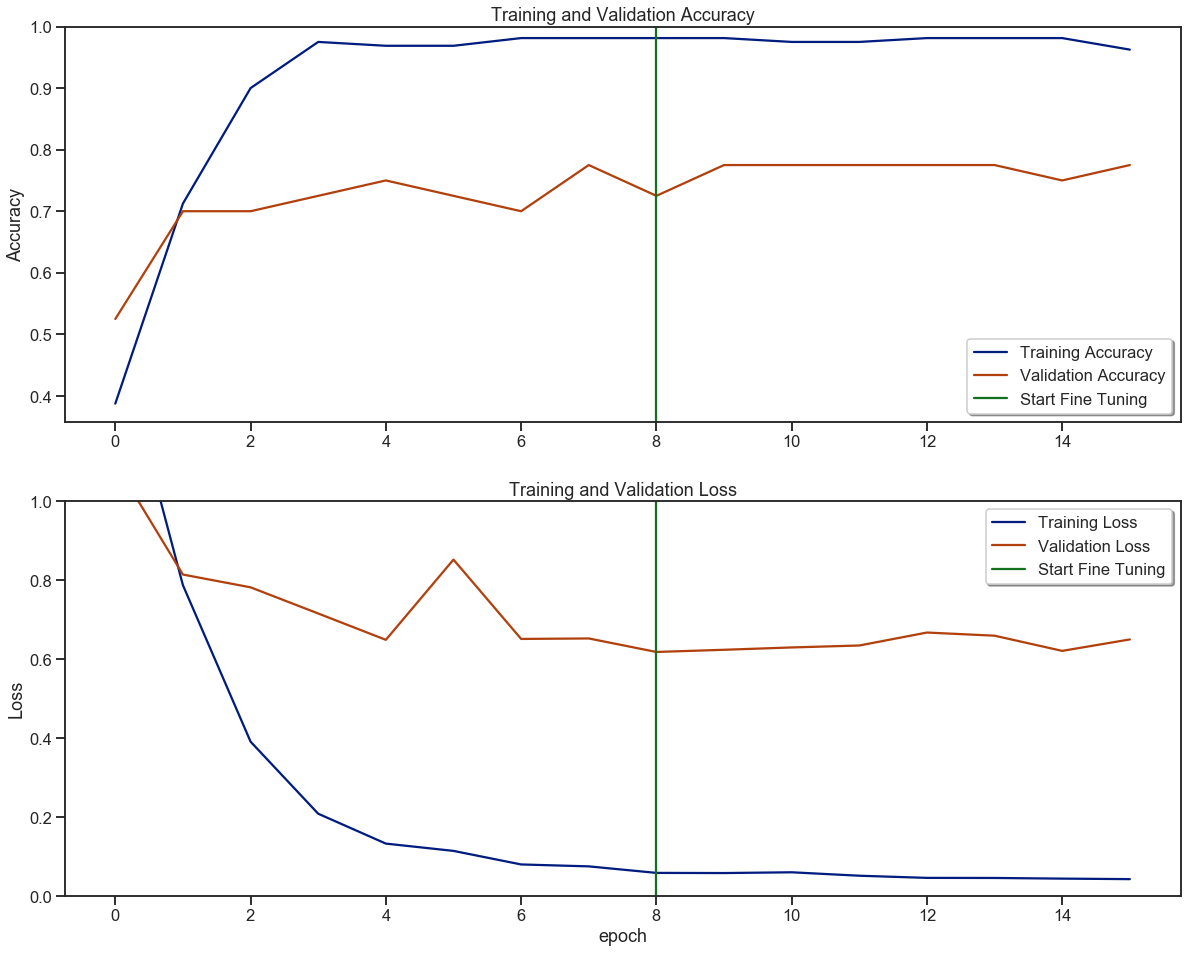

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(20, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best', shadow=True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.ylabel('Loss')
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best', shadow=True)
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning has helped to improve the validation accuracy.

### Performance Metrics

### 1. Precision At Recall

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.8)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

In [18]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=initial_batch_size, verbose=0)

test_loss, test_precision_at_recall = model.evaluate(X_test, y_test, verbose=0)
print('test_precision_at_recall:', test_precision_at_recall)

test_precision_at_recall: 0.8333333134651184


Precision at recall rate was within a good range of 83.3% and outperforms baseline of 50%.

### 2. AUC

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=[tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

In [20]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=initial_batch_size, verbose=0)

test_loss, test_auc = model.evaluate(X_test, y_test, verbose=0)
print('test_auc:', test_auc)

test_auc: 0.9652499556541443


High AUC indicating good true positive rate (recall) and false positive rate trade off.

### 3. Prediction Validation Results

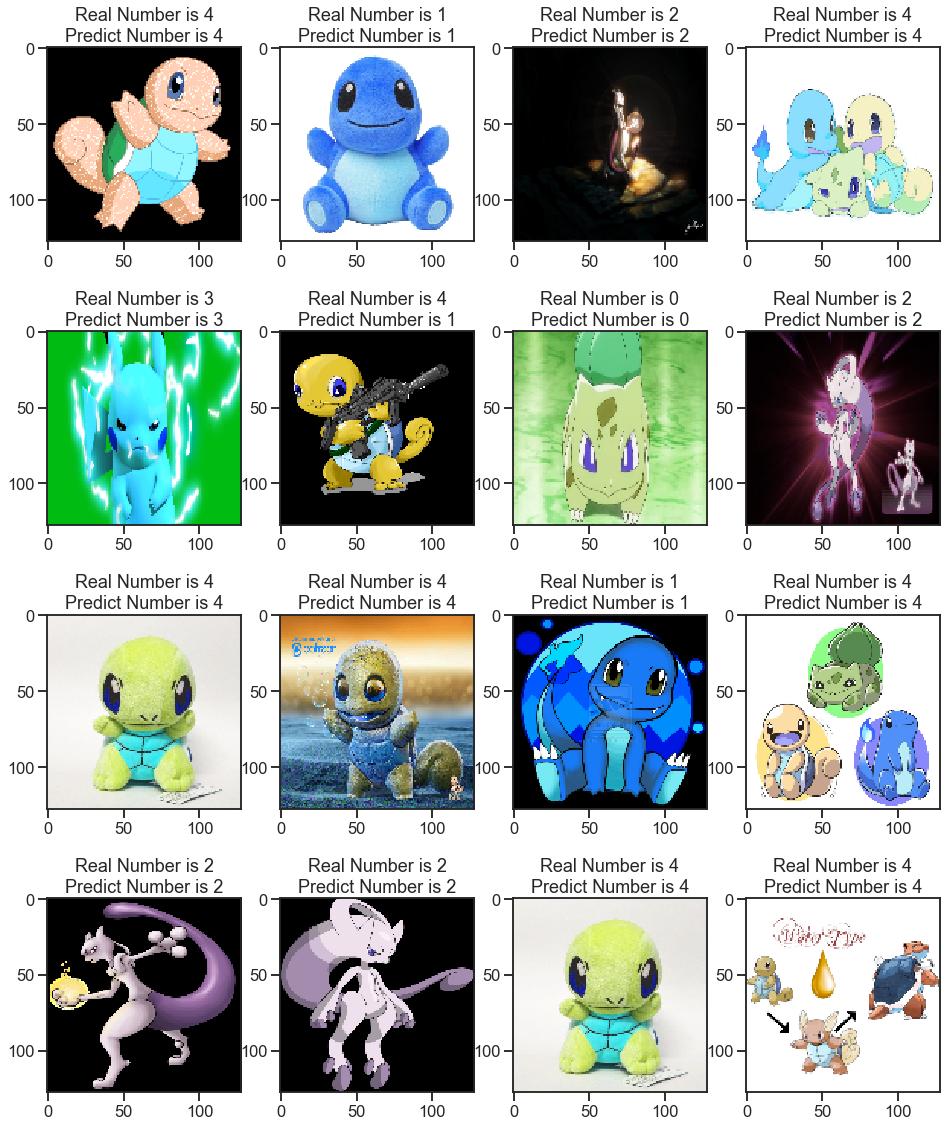

In [21]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2] )

fig, axis = plt.subplots(4, 4, figsize=(16, 20))

for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");
    
#   categories = ['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']

### 4. Confusion Matrix

<Figure size 720x720 with 0 Axes>

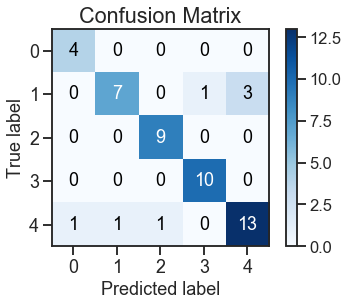

In [22]:
fig = plt.figure(figsize=(10, 10))

y_pred = model.predict(X_test) 

Y_pred = np.argmax(y_pred, 1) 
Y_test = np.argmax(y_test, 1)

skplt.metrics.plot_confusion_matrix(Y_test, Y_pred)
plt.show()

Slightly higher than average false positives of '3' which corresponds to the above validation results where blue Charmanders were observed.

### 5. Test Image Prediction

In [28]:
# image = 'bulbasaur_plush.png'
# image = 'charmander_counter.png'
# image = 'mewtwo_toy.png'
# image = 'pikachu_toy.png'
image = 'squirtle_plush.png'

test_image = cv2.imread(image)
test_image = cv2.resize(test_image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255
test_image = np.expand_dims(test_image, axis=0)

np.set_printoptions(suppress=True)  # suppresses the scientific notations

print(model.predict(test_image))
if np.argmax(model.predict(test_image), axis=-1) == 0:
    print('It\'s a bulbasaur!')
elif np.argmax(model.predict(test_image), axis=-1) == 1:
    print('It\'s a charmander!')
elif np.argmax(model.predict(test_image), axis=-1) == 2:
    print('It\'s a mewtwo!')
elif np.argmax(model.predict(test_image), axis=-1) == 3:
    print('It\'s a pikachu!')
elif np.argmax(model.predict(test_image), axis=-1) == 4:
    print('It\'s a squirtle!')

[[0.00446626 0.00918286 0.00436863 0.00471296 0.9772693 ]]
It's a squirtle!


### Conclusion

A CNN model has been successfully built using Transfer Learning to classify the categories from the Pokemon dataset. Improvements can be made to train the CNN model with a large and general enough dataset. Using transfer learning enables one to take advantage of the previously learned feature maps, without having to start from scratch by training a large model on a large dataset. 